In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

In [3]:
main_df = pd.read_csv('/Users/martyna/.cache/kagglehub/datasets/asaniczka/uk-optimal-product-price-prediction/versions/3/amz_uk_price_prediction_dataset.csv')

In [4]:
df = main_df.copy()

### Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

Crosstab Analysis:

Create a crosstab between the product category and the isBestSeller status.

Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

In [6]:
df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [42]:
result = pd.crosstab(df['category'], df['isBestSeller'])

In [47]:
result

isBestSeller,False,True,Proportion
category,,,
Grocery,9008,556,0.058135
Smart Home Security & Lighting,98,6,0.057692
Health & Personal Care,9017,552,0.057686
Mobile Phone Accessories,248,11,0.042471
Power & Hand Tools,8353,306,0.035339
"Billiard, Snooker & Pool",241,8,0.032129
Pet Supplies,9152,285,0.030200
Home Brewing & Wine Making,239,7,0.028455
Wind Instruments,243,7,0.028000


In [43]:
#removing categories without bestsellers 
result = result[result[True] > 0]


In [44]:
#adding proportion column
result['Proportion'] = result[True] / (result[True] + result[False])

In [45]:
result = result.sort_values(by='Proportion', ascending=False)

In [46]:
#removing categories with proportion < 2%
result = result[result["Proportion"] >= 0.02]

Now we can see the top 3 categories with biggest percentage of best sellers: grocery, smart home security, health & personal care

Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
Compute Cramér's V to understand the strength of association between best-seller status and category

In [32]:
result_raw = pd.crosstab(df['category'], df['isBestSeller'])

In [38]:
_, chi2_pvalue, _, _ = chi2_contingency(result_raw)
chi2_pvalue

np.float64(0.0)

In [39]:
# Check if the chi2_pvalue is smaller than 0.5
float(chi2_pvalue) < 0.05

True

Result- we can rejest the null hypothesis with very strong confidence

In [40]:
# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(result_raw, method='cramer')

0.1222829439760564

0.12 value of Cramer means there is a weak association between the 2 variables.

Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

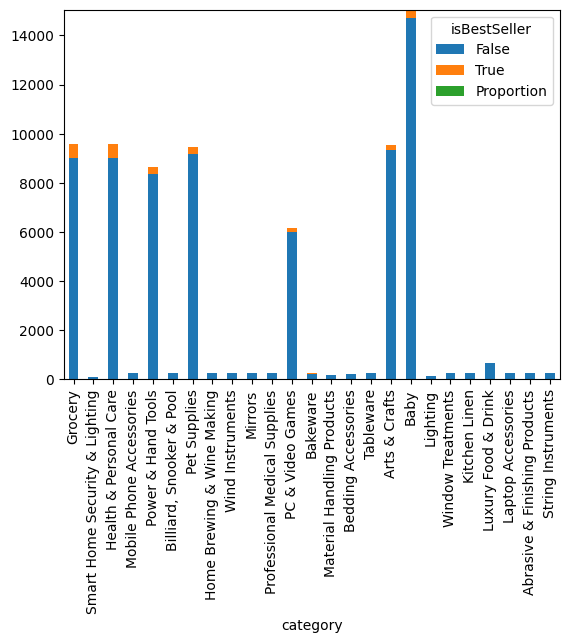

In [51]:
result.plot(kind='bar', stacked=True)
plt.show()

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

In [54]:
# Step 1: Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# Step 2: Calculate IQR
IQR = Q3 - Q1

# Step 3: Define lower and upper bounds for non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Filter out outliers
df_new = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Optional: Print number of rows before and after removing outliers
print(f"Original rows: {len(df)}")
print(f"Rows after removing outliers: {len(df_new)}")

 

Original rows: 2443651
Rows after removing outliers: 2115963


In [55]:
df = df_new 

Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.

In [58]:
top_20 = df.groupby("category")["uid"].count().sort_values(ascending=False).head(20).reset_index()
top_20

,category,uid
0,Sports & Outdoors,694092
1,Beauty,19233
2,Bath & Body,19050
3,Manicure & Pedicure Products,18904
4,"Handmade Clothing, Shoes & Accessories",18811
5,Make-up,18718
6,Skin Care,18686
7,Hair Care,18625
8,Birthday Gifts,18398
9,Handmade Gifts,17948


In [63]:
def plot_violin_plots(df_new, column_to_plot='price'):
    # Get the top 20 categories based on counts
    top_20_categories = df['category'].value_counts().nlargest(20).index
    top_20_df = df[df['category'].isin(top_20_categories)]

    # Split into chunks of 5 categories each
    for i in range(0, len(top_20_categories), 5):
        plt.figure(figsize=(10, 6))
        categories_chunk = top_20_categories[i:i+5]
        sns.violinplot(data=top_20_df[top_20_df['category'].isin(categories_chunk)], 
                       x="category", y=column_to_plot, palette="coolwarm")
        plt.title(f"Violin Plot for Categories {i+1} to {i+5}")
        plt.xticks(rotation=30)
        plt.show()

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_92118/3798419039.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_20_df[top_20_df['category'].isin(categories_chunk)],


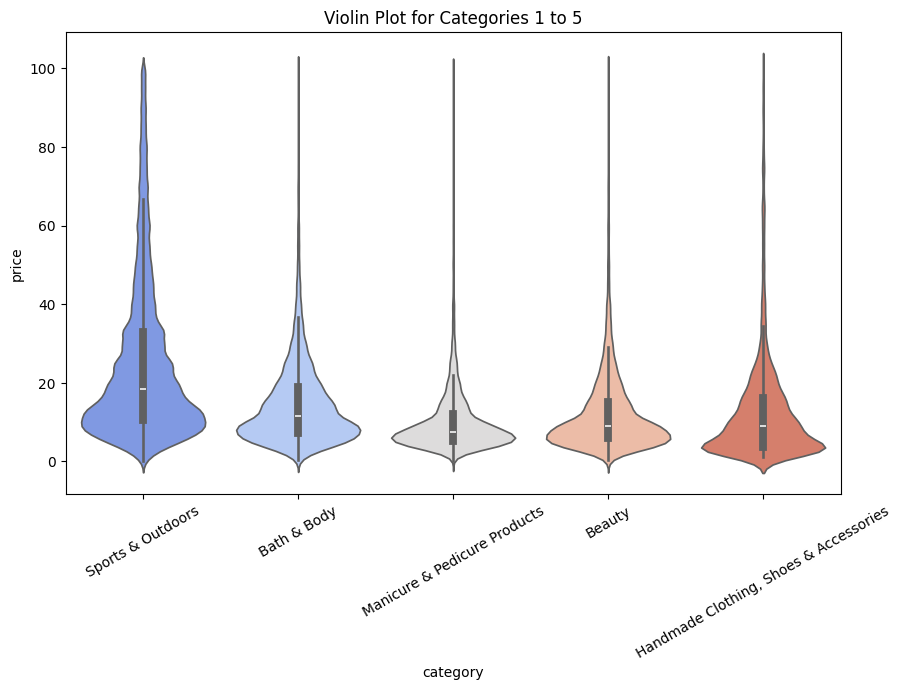

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_92118/3798419039.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_20_df[top_20_df['category'].isin(categories_chunk)],


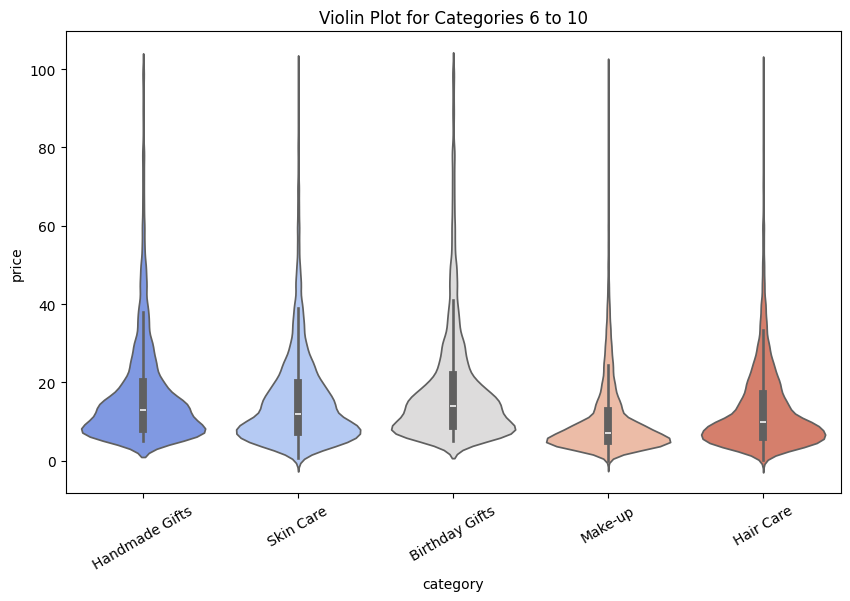

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_92118/3798419039.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_20_df[top_20_df['category'].isin(categories_chunk)],


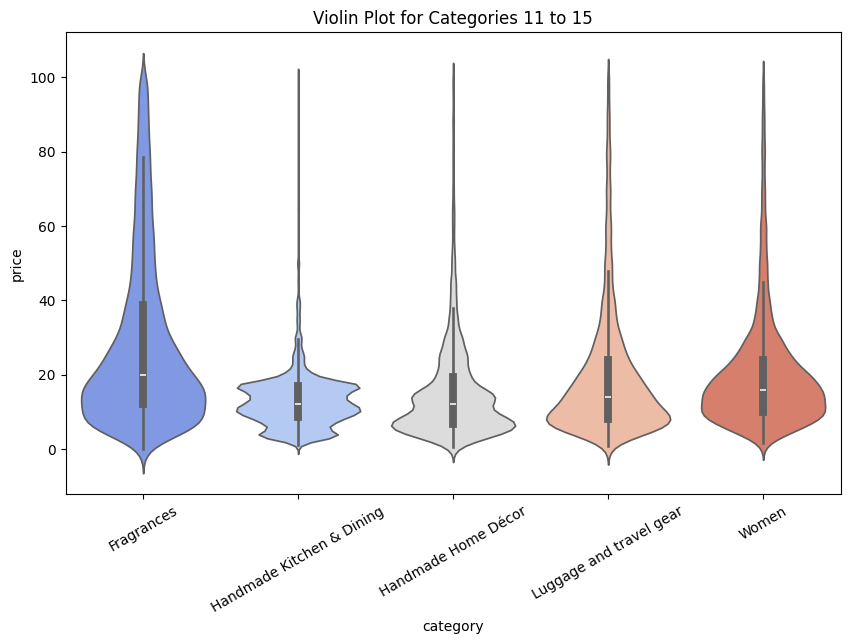

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_92118/3798419039.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_20_df[top_20_df['category'].isin(categories_chunk)],


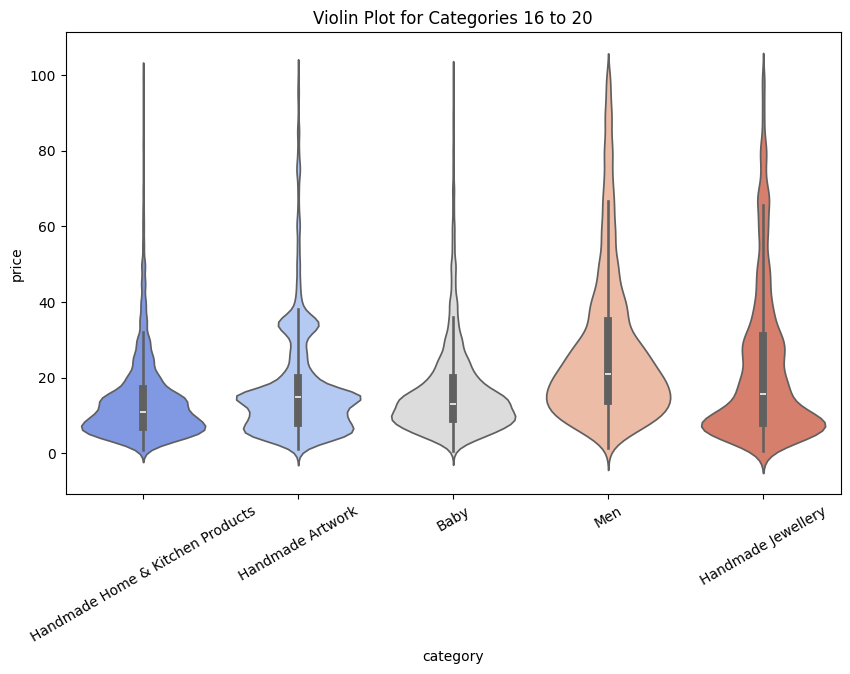

In [64]:
plot_violin_plots(df_new, column_to_plot='price')

Sports and outdoors : long upper tail means that prices are more varied and some are more expensive; median is around 20
Bath & body: more narrow and shorter, meaning that prices are less spread; median is below 20
Manicure & pedicure: values are concentrated around the median price mostly

Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.

In [66]:
df_bar = df_new[df_new["category"].isin(top_20["category"].head(10))]

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_92118/1084333106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bar, x="category", y="price", palette="coolwarm")


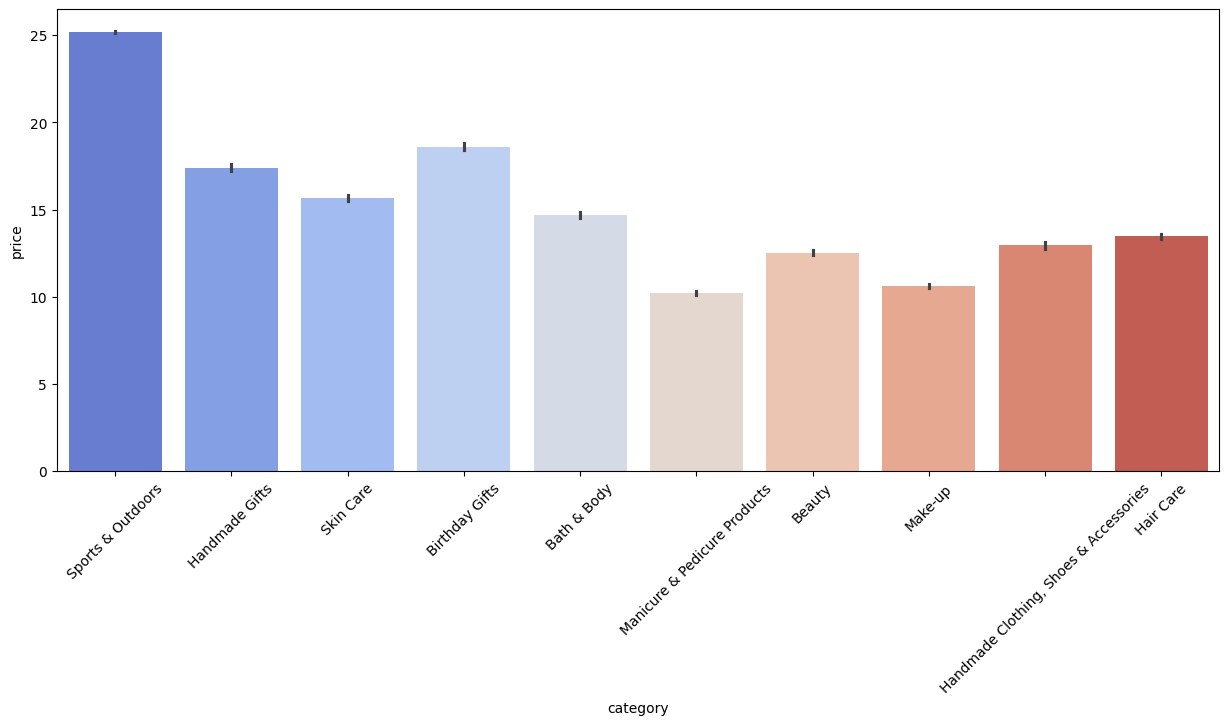

In [72]:
plt.figure(figsize=(15, 6))
sns.barplot(data=df_bar, x="category", y="price", palette="coolwarm")
plt.xticks(rotation=45)
plt.show()

Sports and Outdoors has the highest average price

Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [77]:
#I remove products with no ratings, because nothing was visible
df_rated = df_bar[df_bar["stars"] != 0]

/var/folders/8m/yz8tmn5d3ns2cwtr98zklxtw0000gn/T/ipykernel_92118/1418633880.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_rated, x="category", y="stars", palette="coolwarm")


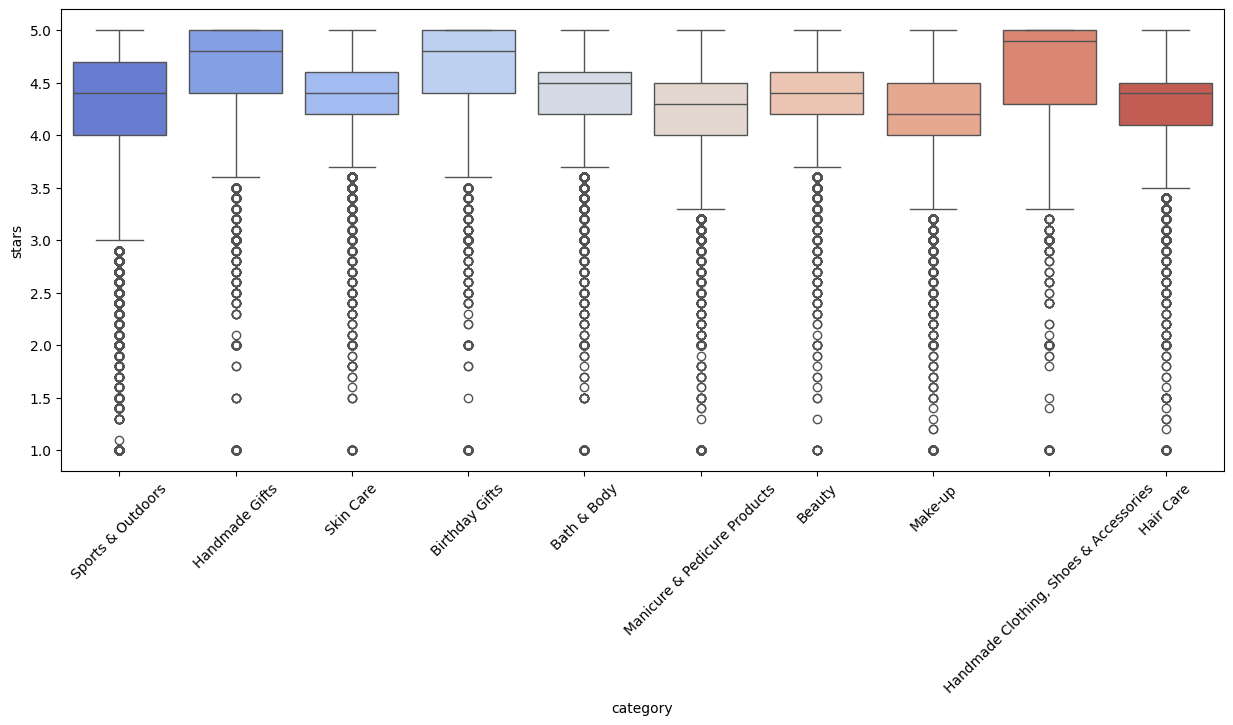

In [78]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_rated, x="category", y="stars", palette="coolwarm")
plt.xticks(rotation=45)
plt.show()

Looks like the best reviews are in handmade gifts and clothing shows and accessories categoreis. Overall there are many many products with no ratings at all, and there are multiple outliers. 

### Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

Calculate the correlation coefficient between price and stars.
Is there a significant correlation between product price and its rating?


In [ ]:
float(df_new['price'].corr(df_new['stars'])) # PEARSON

-0.07767299878181001

In [80]:
float(df_new['price'].corr(df_new['stars'], method="spearman")) # Spearman

-0.06679697280769055

Both show negative correlation, as price increases the ratings are not increasing

Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
Use a correlation heatmap to visualize correlations between all numerical variables.
Examine if product prices typically follow a normal distribution using a QQ plot.

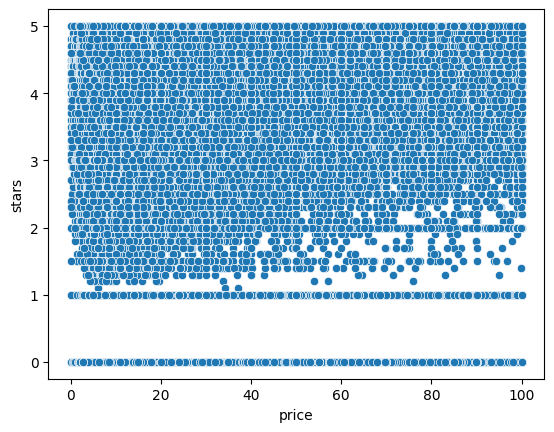

In [81]:
sns.scatterplot(data=df_new, x='price', y='stars')
plt.show()

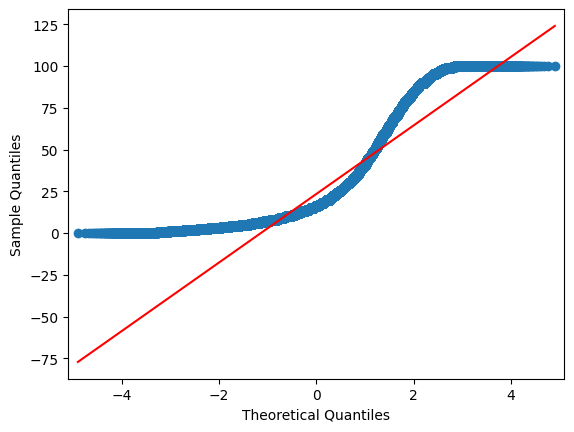

In [82]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(df_new['price'], line='s');
plt.show()

Price doesn't follow a normal distributon

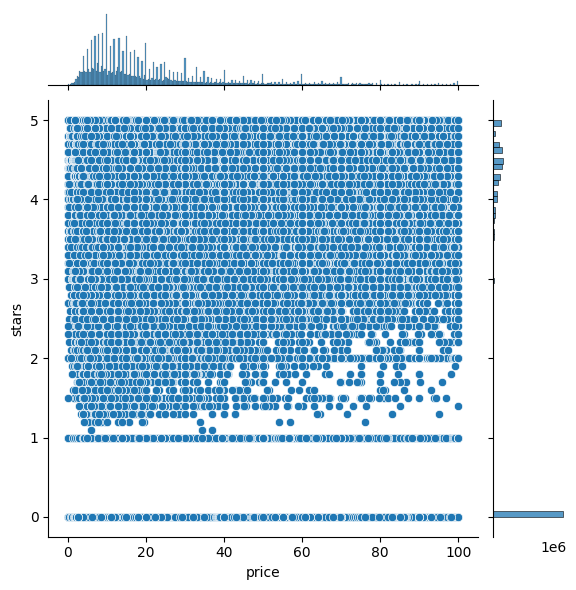

In [83]:
sns.jointplot(y=df_new['stars'], x=df_new['price'])
plt.show()

In [84]:
cat = df_new.select_dtypes(exclude="number")
num = df_new.select_dtypes(include="number")

# Being specific
cat_from_num = num.loc[:, num.nunique() < 20] #cool way of reclassifying categorical columns hiding in numerical values
cat = pd.concat([cat, cat_from_num], axis=1)
num = num.drop(columns=cat_from_num.columns)

In [85]:
correlation_matrix = num.corr()

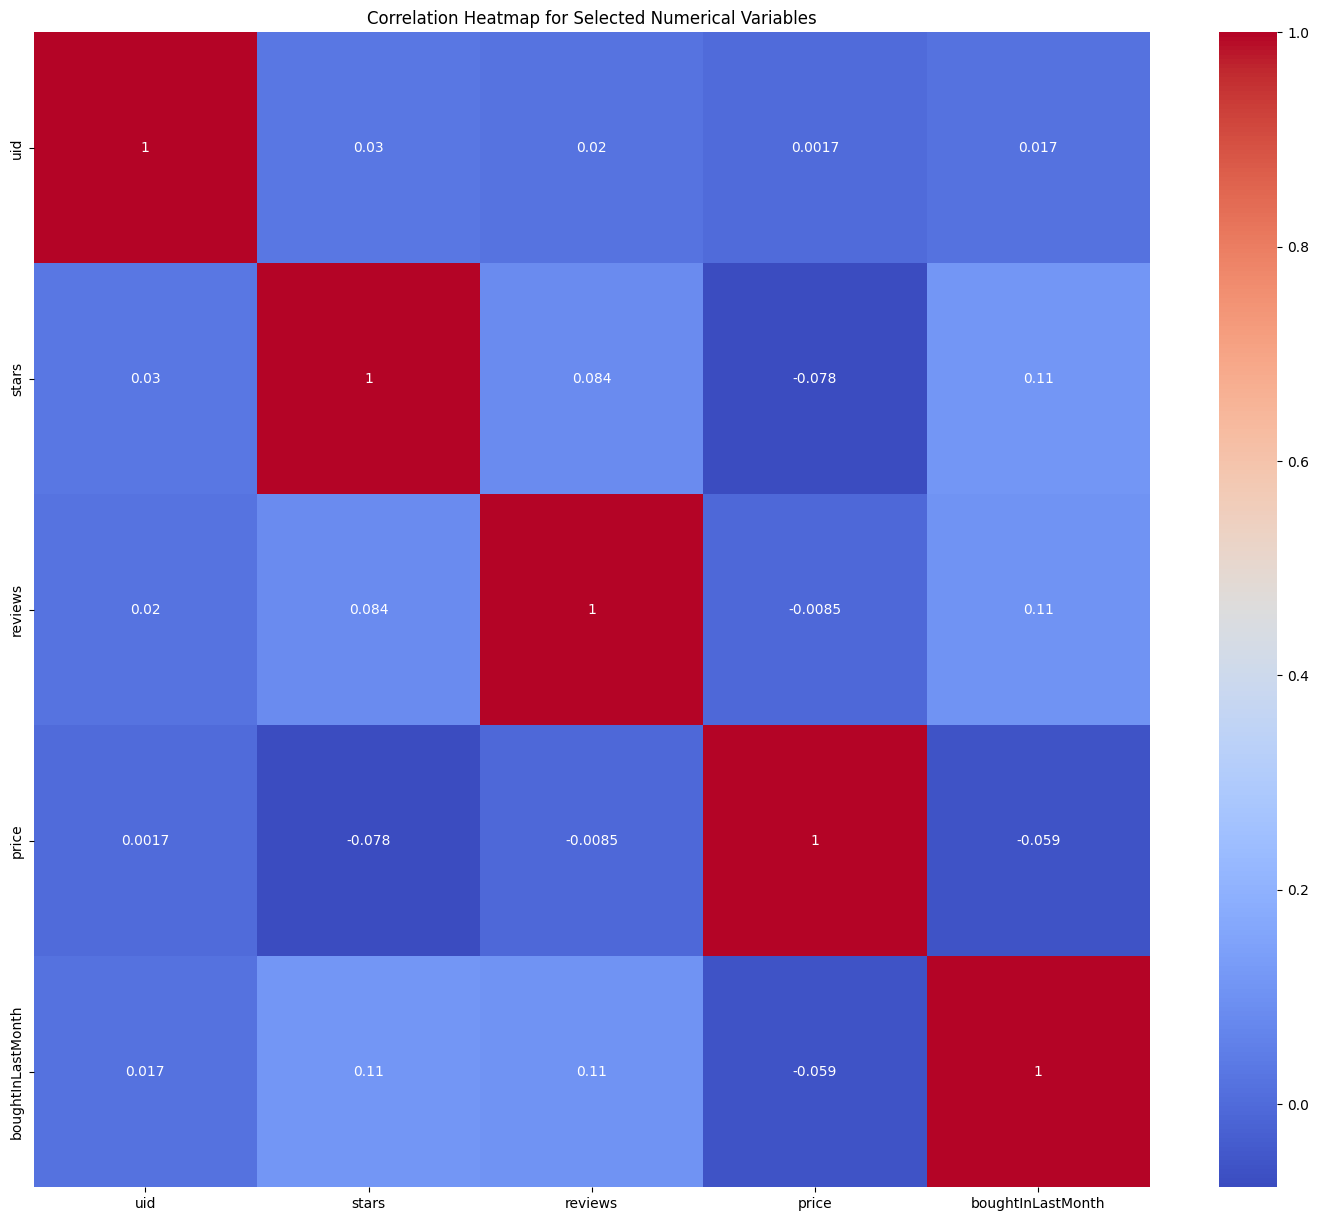

In [86]:
# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

Very low correlations between all of the numerical variables